In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image
import cv2
import os
import re

## Preparing

In [3]:
data_path = '../../data/wheat_detection/'

df_train = pd.read_csv(data_path + 'train.csv')
df_sub = pd.read_csv(data_path + 'sample_submission.csv')

df_train = df_train.drop(columns=['width', 'height', 'source'])

bbox_list = df_train['bbox']
x1, y1, x2, y2 = [], [], [], []
for b in bbox_list:
    bbox = re.findall('([0-9]+[.]?[0-9]*)', b)
    x1.append(float(bbox[0]))
    y1.append(float(bbox[1]))
    x2.append(float(bbox[0]) + float(bbox[2]))
    y2.append(float(bbox[1]) + float(bbox[3]))

df_train['x1'] = x1
df_train['y1'] = y1
df_train['x2'] = x2
df_train['y2'] = y2

image_ids = df_train['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

df_valid = df_train[df_train['image_id'].isin(valid_ids)]
df_train = df_train[df_train['image_id'].isin(train_ids)]

## Datasets

In [4]:
class wheatdataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_ids = self.dataframe['image_id'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        img = Image.open(self.image_dir + image_id + '.jpg')
        img = np.array(img) / 255.
      
    
        img = cv2.imread(self.image_dir + image_id + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
        if self.transform:
            img = self.transform(img)
            
        
        boxes = self.dataframe.loc[self.dataframe['image_id'] == image_id, ['x1','y1','x2','y2']]
        boxes = np.array(boxes)
        boxes = torch.from_numpy(boxes).type(torch.float32)
        
        labels = torch.ones((boxes.shape[0])).type(torch.int64)
        
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        
        return img.type(torch.FloatTensor), targets
    
def collate_fn(batch):
    return tuple(zip(*batch))

## Model

In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model = fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 2 # background & wheat

in_features = model.roi_heads.box_predictor.cls_score.in_features


model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

## Data Loader

In [6]:
TRAIN_DIR = '../../data/wheat_detection/train/'
TEST_DIR = '../../data/wheat_detection/test/'

transform = transforms.Compose([
    transforms.ToTensor()
])

def collate_fn(batch):
    return tuple(zip(*batch))

train_data = wheatdataset(df_train, TRAIN_DIR, transform=transform)

train_loader = DataLoader(train_data, batch_size = 6, shuffle=True, collate_fn=collate_fn)

## Optimizer

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training

In [8]:
train_loss_per_epoch_list = []
train_loss_per_iter_list = []

for e in range(1):
    model.train()
    train_loss_for_epoch = 0
    for i, (images, targets) in enumerate(train_loader):
        
        images = [img.type(torch.FloatTensor).to(device) for img in images]
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model.to(device)(images, targets)
        
        loss = sum(loss for loss in loss_dict.values())
        train_loss_for_epoch += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_per_iter_list.append(loss.cpu().item())
            
        if i % 40 == 0:
            print('Epoch : [%d/%d] ----- Loss : %0.3f' %(i, len(train_loader), loss.item()))
    train_loss_per_epoch_list.append(train_loss_for_epoch)        
    print('Epoch : [%d/%d] ------ Loss : %0.3f' %(i+1, len(train_loader), loss.item()))
    

Epoch : [0/452] ----- Loss : 1.832
Epoch : [40/452] ----- Loss : 1.648
Epoch : [80/452] ----- Loss : 1.321
Epoch : [120/452] ----- Loss : 1.640
Epoch : [160/452] ----- Loss : 1.547
Epoch : [200/452] ----- Loss : 1.318
Epoch : [240/452] ----- Loss : 1.224
Epoch : [280/452] ----- Loss : 1.158
Epoch : [320/452] ----- Loss : 1.245
Epoch : [360/452] ----- Loss : 1.121
Epoch : [400/452] ----- Loss : 0.993
Epoch : [440/452] ----- Loss : 1.144
Epoch : [452/452] ------ Loss : 0.977


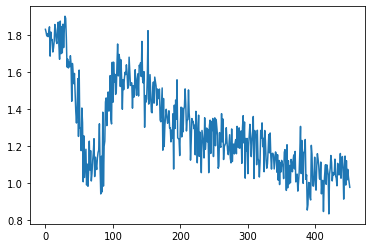

In [11]:
plt.plot(train_loss_per_iter_list)

## Result visualization

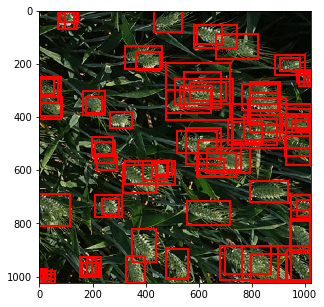

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

valid_data = wheatdataset(df_valid, TRAIN_DIR, transform=transform)
valid_loader = DataLoader(valid_data, batch_size = 2, shuffle=False, collate_fn=collate_fn)

test_image, test_target = iter(valid_loader).next()
test_image = [img.to(device) for img in test_image]

model.eval()
with torch.no_grad():
    model.to(device)
    pred = model(test_image)
    
test_image = test_image[0].cpu().permute(1,2,0).numpy()
pred_boxes = pred[0]['boxes'].cpu().numpy()

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(test_image)

for box in pred_boxes:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

## 비교

In [ ]:
model_raw = fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 2 # background & wheat

in_features = model_raw.roi_heads.box_predictor.cls_score.in_features


model_raw.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_raw

## Accuracy

NameError: name 'wheatdataset' is not defined